<a href="https://colab.research.google.com/github/AnandShegde/pml_baselines/blob/main/pystan/WeibullPoisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
try:
  import pystan
except:
  %pip install -qq pystan
  import pystan
import tensorflow as tf
import seaborn as sns
import numpy as np
import jax
import jax.numpy as jnp
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import arviz as az

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import pickle
file=open('/content/WeibullPoissonData/weibull_poisson','rb')
data=pickle.load(file)
file.close()
data

{'data': array([ 9., 14.,  9., ..., 12., 14., 13.], dtype=float32),
 'prior': {'k': 15, 'lamda': 10}}

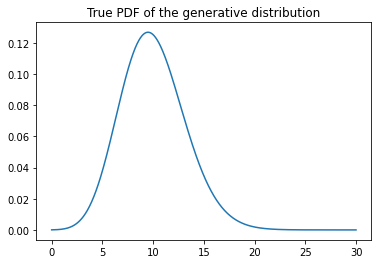

In [24]:
x_space = jnp.linspace(0,30,1000)
poisson = tfd.Poisson(rate=10)
true_pdf = poisson.prob(x_space)
plt.plot(x_space,true_pdf)
plt.title("True PDF of the generative distribution")
plt.show()

In [25]:
samples=data['data']

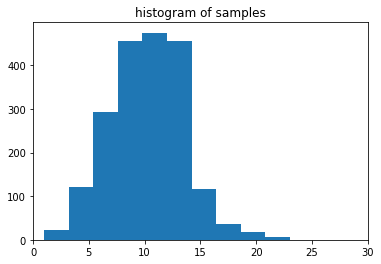

In [26]:
plt.hist(samples)
plt.xlim(0,30)
plt.title("histogram of samples")
plt.show()

In [27]:
WeibullPoisson = """
data {
  int<lower=0> n;
  int x[n];
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda~weibull(10,15);
  x~poisson(lambda);
}
"""

#**Using HMC(Hamiltonian Monte Carlo)**

In [28]:
model_WeibullPoisson = pystan.StanModel(model_code=WeibullPoisson)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3e60283f9b7d28dc8f1fce38d1f77d9d NOW.


In [29]:
data = {
    'n':  len(samples),
    'x': samples.astype(int),
}

In [30]:
model_weibull_hmc = model_WeibullPoisson.sampling(data=data, chains=8, warmup=500, iter=1500)

In [31]:
model_weibull_hmc

Inference for Stan model: anon_model_3e60283f9b7d28dc8f1fce38d1f77d9d.
8 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda  10.08  1.3e-3   0.07   9.94  10.03  10.08  10.13  10.22   3211    1.0
lp__    2.6e4    0.01   0.71  2.6e4  2.6e4  2.6e4  2.6e4  2.6e4   3620    1.0

Samples were drawn using NUTS at Thu Jun 23 09:54:34 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [32]:
lambda_hmc=(model_weibull_hmc.extract())['lambda'].mean()
lambda_hmc

10.082690343138827

In [33]:
# az.plot_trace(model_weibull_hmc, figsize = (12, 4))

In [34]:
weibullhmc_df = model_weibull_hmc.to_dataframe()
weibullhmc_df
lambda_hmc = weibullhmc_df['lambda']
lambda_hmc

0       10.027995
1       10.003163
2       10.003163
3       10.139234
4       10.120233
          ...    
7995    10.151776
7996    10.177955
7997    10.253776
7998    10.153791
7999    10.046646
Name: lambda, Length: 8000, dtype: float64

# **Using Variational Inference(VI)**

In [35]:
model_Weibull_vi=model_WeibullPoisson.vb(data=data)

In [36]:
# model_bernoulli_vi

In [37]:
lambda_vi=model_Weibull_vi.get('mean_pars')
lambda_vi

[10.118240780924436]

In [38]:
# az.plot_trace(data=np.array(model_Weibull_vi.get('sampler_params')[0]), figsize = (12, 4))

#**Plotting the distribution**




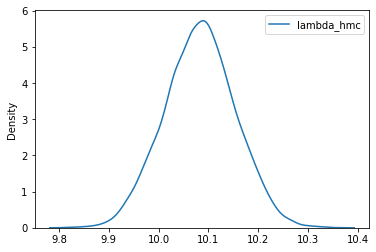

In [42]:
sns.kdeplot(lambda_hmc,label="lambda_hmc")
plt.legend()
plt.show()

In [40]:
lambda_hmc=jnp.array(lambda_hmc)
lambda_hmc

DeviceArray([10.027995, 10.003162, 10.003162, ..., 10.253777, 10.15379 ,
             10.046646], dtype=float32)

In [41]:
# lambda_hmc=jnp.array(lambda_hmc)
# with open("/content/WeibullPoisson_Data/HMC_Stan",'wb') as f:
#     pickle.dump(lambda_hmc, f,protocol = 1)